In [2]:
import pandas as pd
class PSAR:

  def __init__(self, init_af=0.02, max_af=0.2, af_step=0.02):
    self.max_af = max_af
    self.init_af = init_af
    self.af = init_af
    self.af_step = af_step
    self.extreme_point = None
    self.high_price_trend = []
    self.low_price_trend = []
    self.high_price_window = deque(maxlen=2)
    self.low_price_window = deque(maxlen=2)

    self.psar_list = []
    self.af_list = []
    self.ep_list = []
    self.high_list = []
    self.low_list = []
    self.trend_list = []
    self._num_days = 0

  def calcPSAR(self, high, low):
    if self._num_days >= 3:
      psar = self._calcPSAR()
    else:
      psar = self._initPSARVals(high, low)

    psar = self._updateCurrentVals(psar, high, low)
    self._num_days += 1

    return psar

  def _initPSARVals(self, high, low):
    if len(self.low_price_window) <= 1:
      self.trend = None
      self.extreme_point = high
      return None

    if self.high_price_window[0] < self.high_price_window[1]:
      self.trend = 1
      psar = min(self.low_price_window)
      self.extreme_point = max(self.high_price_window)
    else: 
      self.trend = 0
      psar = max(self.high_price_window)
      self.extreme_point = min(self.low_price_window)

    return psar

  def _calcPSAR(self):
    prev_psar = self.psar_list[-1]
    if self.trend == 1: # Up
      psar = prev_psar + self.af * (self.extreme_point - prev_psar)
      psar = min(psar, min(self.low_price_window))
    else:
      psar = prev_psar - self.af * (prev_psar - self.extreme_point)
      psar = max(psar, max(self.high_price_window))

    return psar

  def _updateCurrentVals(self, psar, high, low):
    if self.trend == 1:
      self.high_price_trend.append(high)
    elif self.trend == 0:
      self.low_price_trend.append(low)

    psar = self._trendReversal(psar, high, low)

    self.psar_list.append(psar)
    self.af_list.append(self.af)
    self.ep_list.append(self.extreme_point)
    self.high_list.append(high)
    self.low_list.append(low)
    self.high_price_window.append(high)
    self.low_price_window.append(low)
    self.trend_list.append(self.trend)

    return psar

  def _trendReversal(self, psar, high, low):
    # Checks for reversals
    reversal = False
    if self.trend == 1 and psar > low:
      self.trend = 0
      psar = max(self.high_price_trend)
      self.extreme_point = low
      reversal = True
    elif self.trend == 0 and psar < high:
      self.trend = 1
      psar = min(self.low_price_trend)
      self.extreme_point = high
      reversal = True

    if reversal:
      self.af = self.init_af
      self.high_price_trend.clear()
      self.low_price_trend.clear()
    else:
        if high > self.extreme_point and self.trend == 1:
          self.af = min(self.af + self.af_step, self.max_af)
          self.extreme_point = high
        elif low < self.extreme_point and self.trend == 0:
          self.af = min(self.af + self.af_step, self.max_af)
          self.extreme_point = low

    return psar

In [1]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install yfinance

Selecting previously unselected package libta-lib0.
(Reading database ... 128276 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.0/272.0 KB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta-lib: filename=TA_Lib-0.4.25-cp39-cp39-linux_x86_64.whl size=2261258 sha256=c504f9e2ed6b783cdee92671fc2e1

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import talib as ta
from scipy.signal import argrelextrema
from collections import deque

def rsiuse(dfa1):
    global data,hh,lh,ll,hl,hh_idx,lh_idx,ll_idx,hl_idx,price,dates
    data=dfa1
    price = data['Close'].values
    dates = data.index
    # Get higher highs, lower lows, etc.
    order = 5
    hh = getHigherHighs(price, order)
    lh = getLowerHighs(price, order)
    ll = getLowerLows(price, order)
    hl = getHigherLows(price, order)
    # Get confirmation indices
    hh_idx = np.array([i[1] + order for i in hh])
    lh_idx = np.array([i[1] + order for i in lh])
    ll_idx = np.array([i[1] + order for i in ll])
    hl_idx = np.array([i[1] + order for i in hl])
    return data
def getHigherLows(data: np.array, order=5, K=2):
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are higher than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] < lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getLowerHighs(data: np.array, order=5, K=2):
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are lower than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] > highs[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def getHigherHighs(data: np.array, order=5, K=2):
  # Get highs
  high_idx = argrelextrema(data, np.greater, order=order)[0]
  highs = data[high_idx]
  # Ensure consecutive highs are higher than previous highs
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(high_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if highs[i] < highs[i-1]:
      ex_deque.clear()
    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())
  
  return extrema

def getLowerLows(data: np.array, order=5, K=2):
  # Get lows
  low_idx = argrelextrema(data, np.less, order=order)[0]
  lows = data[low_idx]
  # Ensure consecutive lows are lower than previous lows
  extrema = []
  ex_deque = deque(maxlen=K)
  for i, idx in enumerate(low_idx):
    if i == 0:
      ex_deque.append(idx)
      continue
    if lows[i] > lows[i-1]:
      ex_deque.clear()

    ex_deque.append(idx)
    if len(ex_deque) == K:
      extrema.append(ex_deque.copy())

  return extrema

def calcRSI(data, P=14):
  data['diff_close'] = data['Close'] - data['Close'].shift(1)
  data['gain'] = np.where(data['diff_close']>0, data['diff_close'], 0)
  data['loss'] = np.where(data['diff_close']<0, np.abs(data['diff_close']), 0)
  data[['init_avg_gain', 'init_avg_loss']] = data[
    ['gain', 'loss']].rolling(P).mean()
  avg_gain = np.zeros(len(data))
  avg_loss = np.zeros(len(data))
  for i, _row in enumerate(data.iterrows()):
    row = _row[1]
    if i < P - 1:
      last_row = row.copy()
      continue
    elif i == P-1:
      avg_gain[i] += row['init_avg_gain']
      avg_loss[i] += row['init_avg_loss']
    else:
      avg_gain[i] += ((P - 1) * avg_gain[i-1] + row['gain']) / P
      avg_loss[i] += ((P - 1) * avg_loss[i-1] + row['loss']) / P
          
    last_row = row.copy()
      
  data['avg_gain'] = avg_gain
  data['avg_loss'] = avg_loss
  data['RS'] = data['avg_gain'] / data['avg_loss']
  data['RSI'] = 100 - 100 / (1 + data['RS'])
  return data
def getHHIndex(data: np.array, order=5, K=2):
  extrema = getHigherHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLHIndex(data: np.array, order=5, K=2):
  extrema = getLowerHighs(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getLLIndex(data: np.array, order=5, K=2):
  extrema = getLowerLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getHLIndex(data: np.array, order=5, K=2):
  extrema = getHigherLows(data, order, K)
  idx = np.array([i[-1] + order for i in extrema])
  return idx[np.where(idx<len(data))]

def getPeaks(data, key='Close', order=5, K=2):
  vals = data[key].values
  hh_idx = getHHIndex(vals, order, K)
  lh_idx = getLHIndex(vals, order, K)
  ll_idx = getLLIndex(vals, order, K)
  hl_idx = getHLIndex(vals, order, K)

  data[f'{key}_highs'] = np.nan
  data[f'{key}_highs'][hh_idx] = 1
  data[f'{key}_highs'][lh_idx] = -1
  data[f'{key}_highs'] = data[f'{key}_highs'].ffill().fillna(0)
  data[f'{key}_lows'] = np.nan
  data[f'{key}_lows'][ll_idx] = 1
  data[f'{key}_lows'][hl_idx] = -1
  data[f'{key}_lows'] = data[f'{key}_highs'].ffill().fillna(0)
  return data
def RSIDivergenceStrategy(data, P=14, order=5, K=2):
  data = getPeaks(data, key='Close', order=order, K=K)
  data = calcRSI(data, P=P)
  data = getPeaks(data, key='RSI', order=order, K=K)

  position = np.zeros(data.shape[0])
  for i, (t, row) in enumerate(data.iterrows()):
    if np.isnan(row['RSI']):
        continue
    # If no position is on
    if position[i-1] == 0:
      # Buy if indicator to higher low and price to lower low
      if row['Close_lows'] == -1 and row['RSI_lows'] == 1:
        if row['RSI'] < 50:
          position[i] = 1
          entry_rsi = row['RSI'].copy()

      # Short if price to higher high and indicator to lower high
      elif row['Close_highs'] == 1 and row['RSI_highs'] == -1:
        if row['RSI'] > 50:
          position[i] = -1
          entry_rsi = row['RSI'].copy()

    # If current position is long
    elif position[i-1] == 1:
        if row['RSI'] < 50 and row['RSI'] < entry_rsi:
            position[i] = 1
  
    # If current position is short
    elif position[i-1] == -1:
        if row['RSI'] < 50 and row['RSI'] > entry_rsi:
            position[i] = -1

  data['position'] = position
  return calcReturns(data)

def calcReturns(df):
  # Helper function to avoid repeating too much code
  df['returns'] = df['Close'] / df['Close'].shift(1)
  df['log_returns'] = np.log(df['returns'])
  df['strat_returns'] = df['position'].shift(1) * df['returns']
  df['strat_log_returns'] = df['position'].shift(1) * df['log_returns']
  df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
  df['strat_cum_returns'] = np.exp(df['strat_log_returns'].cumsum()) - 1
  df['peak'] = df['cum_returns'].cummax()
  df['strat_peak'] = df['strat_cum_returns'].cummax()
  return df
def rsidiver():
    position_df = RSIDivergenceStrategy(data)
    positions = position_df['position'].tolist()
    rsi_divergent_signal=positions
    return rsi_divergent_signal

In [372]:
def findindi(Name,Real_name,Syear,Smonth,Sday,Eyear,Emonth,Eday):
    import datetime
    import pandas_datareader.data as web
    import matplotlib.pyplot as plt
    import numpy as np
    import talib as ta
    import pandas as pd
    import yfinance as yf
    from collections import deque
    import pandas_datareader as pdr
    from scipy import stats
    from scipy import signal as sg
    import plotly.express as px
    import plotly.graph_objects as go
    global obv,dfa1_all
	#preprocess data
    Sdate ="%s-%s-%s" % (Syear,Smonth,Sday)
    Edate ="%s-%s-%s" % (Eyear,Emonth,Eday)
    start=datetime.datetime(Syear,Smonth,Sday)
    end=datetime.datetime(Eyear,Emonth,Eday)
    Stockdata=yf.download(Name,start,end)
    dfa1=Stockdata
    Byear = Syear-1
    start=datetime.datetime(Byear,Smonth,Sday)
    end=datetime.datetime(Eyear,Emonth,Eday)
    Stockdata=yf.download(Name,start,end)
    dfa1_all=Stockdata

    def psar_changetrend_signal_func():
        global psar_changetrend_signal
        ticker = Name
        yfObj = yf.Ticker(ticker)
        yfO = yfObj.history(start=Sdate, end=Edate)[['High', 'Low']].round(2)
        yfO=yfO.loc[Sdate:Edate]
        yfO.reset_index(inplace=True)
        indic = PSAR()
        yfO['PSAR'] = yfO.apply(lambda x: indic.calcPSAR(x['High'], x['Low']), axis=1)
        yfO['Trend'] = indic.trend_list
        indic._calcPSAR()
        psar_changetrend_signal=[0]*len(yfO['Trend'])
        for idx,i in enumerate(yfO['Trend']):
            if (pd.isna(i) or idx==0):
                psar_changetrend_signal[idx]=0
            else:
                if (yfO['Trend'][idx-1]==0 and yfO['Trend'][idx]==1):
                    psar_changetrend_signal[idx]=1
                elif(yfO['Trend'][idx-1]==1 and yfO['Trend'][idx]==0):
                    psar_changetrend_signal[idx]=-1
                else:
                    psar_changetrend_signal[idx]=0
    psar_changetrend_signal_func()
    
    def psar_trend_signal_func():
        global psar_trend_signal
        ticker = Name
        yfObj = yf.Ticker(ticker)
        yfO = yfObj.history(start=Sdate, end=Edate)[['High', 'Low']].round(2)
        yfO=yfO.loc[Sdate:Edate]
        yfO.reset_index(inplace=True)
        indic = PSAR()
        yfO['PSAR'] = yfO.apply(lambda x: indic.calcPSAR(x['High'], x['Low']), axis=1)
        yfO['Trend'] = indic.trend_list
        indic._calcPSAR()
        psar_trend_signal=[0]*len(yfO['Trend'])
        for idx,i in enumerate(yfO['Trend']):
            if (yfO['Trend'][idx]==1):
                psar_trend_signal[idx]=1
            elif(yfO['Trend'][idx]==0):
                psar_trend_signal[idx]=-1
            else:
                psar_trend_signal[idx]=0
    psar_trend_signal_func()

    MA30=ta.MA(dfa1_all['Close'], timeperiod=30, matype=0)
    MA30=MA30.loc[Sdate:Edate]
    MA30=MA30.array
    dfa1['MA30']=MA30

    MA50=ta.MA(dfa1_all['Close'], timeperiod=50, matype=0)
    MA50=MA50.loc[Sdate:Edate]
    MA50=MA50.array
    dfa1['MA50']=MA50

    MA200=ta.MA(dfa1_all['Close'], timeperiod=200, matype=0)
    MA200=MA200.loc[Sdate:Edate]
    MA200=MA200.array
    dfa1['MA200']=MA200
    
    MA100=ta.MA(dfa1_all['Close'], timeperiod=100, matype=0)
    MA100=MA100.loc[Sdate:Edate]
    MA100=MA100.array
    dfa1['MA100']=MA100
      
    MA25=ta.MA(dfa1_all['Close'], timeperiod=25, matype=0)
    MA25=MA25.loc[Sdate:Edate]
    MA25=MA25.array
    dfa1['MA25']=MA25
    
    MA89=ta.MA(dfa1_all['Close'], timeperiod=89, matype=0)
    MA89=MA89.loc[Sdate:Edate]
    MA89=MA89.array
    dfa1['MA89']=MA89
    
    MA21=ta.MA(dfa1_all['Close'], timeperiod=21, matype=0)
    MA21=MA21.loc[Sdate:Edate]
    MA21=MA21.array
    dfa1['MA21']=MA21

    ADX=ta.ADX(dfa1_all['High'], dfa1_all['Low'], dfa1_all['Close'], timeperiod=14)
    ADX=ADX.loc[Sdate:Edate]
    ADX=ADX.array
    dfa1['ADX']=ADX
    plus_DMI = ta.PLUS_DM(dfa1_all['High'], dfa1_all['Low'], timeperiod=14)
    minus_DMI= ta.MINUS_DM(dfa1_all['High'], dfa1_all['Low'], timeperiod=14)
    plus_DMI=plus_DMI.loc[Sdate:Edate]
    minus_DMI=minus_DMI.loc[Sdate:Edate]
    plus_DMI=plus_DMI.array
    minus_DMI=minus_DMI.array
    dfa1['plus_DMI']=plus_DMI
    dfa1['minus_DMI']=minus_DMI
    prices, pdi, ndi, adx=dfa1['Close'], dfa1['plus_DMI'], dfa1['minus_DMI'], dfa1['ADX']

    MA5=ta.MA(dfa1_all['Close'], timeperiod=5, matype=0)
    MA5=MA5.loc[Sdate:Edate]
    MA5=MA5.array
    dfa1['MA5']=MA5

    MA10=ta.MA(dfa1_all['Close'], timeperiod=10, matype=0)
    MA10=MA10.loc[Sdate:Edate]
    MA10=MA10.array
    dfa1['MA10']=MA10   

    MA12=ta.MA(dfa1_all['Close'], timeperiod=12, matype=0)
    MA12=MA12.loc[Sdate:Edate]
    MA12=MA12.array
    dfa1['MA12']=MA12   

    MA21=ta.MA(dfa1_all['Close'], timeperiod=21, matype=0)
    MA21=MA21.loc[Sdate:Edate]
    MA21=MA21.array
    dfa1['MA12']=MA12   

    MA7=ta.MA(dfa1_all['Close'], timeperiod=12, matype=0)
    MA7=MA7.loc[Sdate:Edate]
    MA7=MA7.array
    dfa1['MA7']=MA7   

    MA16=ta.MA(dfa1_all['Close'], timeperiod=21, matype=0)
    MA16=MA16.loc[Sdate:Edate]
    MA16=MA16.array
    dfa1['MA16']=MA16  

    obv = ta.OBV(dfa1_all["Close"], dfa1_all["Volume"])
    obv_mean=obv.rolling(20).mean()
    obv_mean=obv_mean.loc[Sdate:Edate]
    data=dfa1['Open']

    def ma12_21_signal_func():
        global ma12_21_signal
        signal=0
        ma12_21_signal=[]
        for i in range(len(dfa1)):
            if dfa1['MA12'][i] > dfa1['MA21'][i]:
                if signal != 1:
                    signal = 1
                    ma12_21_signal.append(signal)
                else:
                    ma12_21_signal.append(0)
            elif dfa1['MA12'][i] < dfa1['MA21'][i]:
                if signal != -1:
                    signal = -1
                    ma12_21_signal.append(signal)
                else:
                    ma12_21_signal.append(0)
            else:
                ma12_21_signal.append(0)

    def ma7_16_signal_func():
        global ma7_16_signal
        signal=0
        ma7_16_signal=[]
        for i in range(len(dfa1)):
            if dfa1['MA7'][i] > dfa1['MA16'][i]:
                if signal != 1:
                    signal = 1
                    ma7_16_signal.append(signal)
                else:
                    ma7_16_signal.append(0)
            elif dfa1['MA7'][i] < dfa1['MA16'][i]:
                if signal != -1:
                    signal = -1
                    ma7_16_signal.append(signal)
                else:
                    ma7_16_signal.append(0)
            else:
                ma7_16_signal.append(0)


    def ma25_89_signal_func():
        global ma25_89_signal
        signal=0
        ma25_89_signal=[]
        for i in range(len(dfa1)):
            if dfa1['MA25'][i] > dfa1['MA89'][i]:
                if signal != 1:
                    signal = 1
                    ma25_89_signal.append(signal)
                else:
                    ma25_89_signal.append(0)
            elif dfa1['MA25'][i] < dfa1['MA89'][i]:
                if signal != -1:
                    signal = -1
                    ma25_89_signal.append(signal)
                else:
                    ma25_89_signal.append(0)
            else:
                ma25_89_signal.append(0)

    def ma21_89_signal_func():
        global ma21_89_signal
        signal=0
        ma21_89_signal=[]
        for i in range(len(dfa1)):
            if dfa1['MA21'][i] > dfa1['MA89'][i]:
                if signal != 1:
                    signal = 1
                    ma21_89_signal.append(signal)
                else:
                    ma21_89_signal.append(0)
            elif dfa1['MA21'][i] < dfa1['MA89'][i]:
                if signal != -1:
                    signal = -1
                    ma21_89_signal.append(signal)
                else:
                    ma21_89_signal.append(0)
            else:
                ma21_89_signal.append(0)
    def ma30_200_signal_func():
        global ma30_200_signal
        ma30_200_signal = []
        signal = 0
        for i in range(len(dfa1)):
            if dfa1['MA30'][i] > dfa1['MA200'][i]:
                if signal != 1:
                    signal = 1
                    ma30_200_signal.append(signal)
                else:
                    ma30_200_signal.append(0)
            elif dfa1['MA30'][i] < dfa1['MA200'][i]:
                if signal != -1:
                    signal = -1
                    ma30_200_signal.append(signal)
                else:
                    ma30_200_signal.append(0)
            else:
                ma30_200_signal.append(0)
                     
    def ma5_10_signal_func():
        global ma5_10_signal
        signal = 0
        ma5_10_signal=[]
        for i in range(len(dfa1)):
            if dfa1['MA5'][i] > dfa1['MA10'][i]:
                if signal != 1:
                    signal = 1
                    ma5_10_signal.append(signal)
                else:
                    ma5_10_signal.append(0)
            elif dfa1['MA5'][i] < dfa1['MA10'][i]:
                if signal != -1:
                    signal = -1
                    ma5_10_signal.append(signal)
                else:
                    ma5_10_signal.append(0)
            else:
                ma5_10_signal.append(0)

    def ma50_200_signal_func():
        global ma50_200_signal
        ma50_200_signal=[]
        signal = 0
        for i in range(len(dfa1)):
            if dfa1['MA50'][i] > dfa1['MA200'][i]:
                if signal != 1:
                    signal = 1
                    ma50_200_signal.append(signal)
                else:
                    ma50_200_signal.append(0)
            elif dfa1['MA50'][i] < dfa1['MA200'][i]:
                if signal != -1:
                    signal = -1
                    ma50_200_signal.append(signal)
                else:
                    ma50_200_signal.append(0)
            else:
                ma50_200_signal.append(0) 
    
    def ma50_100_signal_func():
        global ma50_100_signal
        ma50_100_signal=[]
        signal=0
        for i in range(len(dfa1)):
            if dfa1['MA50'][i] > dfa1['MA100'][i]:
                if signal != 1:
                    signal = 1
                    ma50_100_signal.append(signal)
                else:
                    ma50_100_signal.append(0)
            elif dfa1['MA50'][i] < dfa1['MA100'][i]:
                if signal != -1:
                    signal = -1
                    ma50_100_signal.append(signal)
                else:
                    ma50_100_signal.append(0)
            else:
                ma50_100_signal.append(0)  

    def ma30_50_signal_func():
        global ma30_50_signal
        ma30_50_signal = []
        signal = 0        
        for i in range(len(dfa1)):
            if dfa1['MA30'][i] > dfa1['MA50'][i]:
                if signal != 1:
                    signal = 1
                    ma30_50_signal.append(signal)
                else:
                    ma30_50_signal.append(0)
            elif dfa1['MA30'][i] < dfa1['MA50'][i]:
                if signal != -1:
                    signal = -1
                    ma30_50_signal.append(signal)
                else:
                    ma30_50_signal.append(0)
            else:
                ma30_50_signal.append(0)

    def obv_signal_func():
        global obv_signal
        obv_signal = []
        signal = 0
        for i in range(len(obv_mean)):
            if obv[i] > obv_mean[i]:
                if signal != 1:
                    signal = 1
                    obv_signal.append(signal)
                else:
                    obv_signal.append(0)
            elif obv[i] < obv_mean[i]:
                if signal != -1:
                    signal = -1
                    obv_signal.append(signal)
                else:
                    obv_signal.append(0)
            else:
                obv_signal.append(0)
    
    def sma100_signal_func():
        global sma100_signal,prices,MA100
        MA100=ta.MA(dfa1_all['Close'], timeperiod=100, matype=0)
        MA100=MA100.loc[Sdate:Edate]
        MA100=MA100.array
        dfa1['MA100']=MA100
        prices=dfa1['Close']
        signal = 0
        sma100_signal=[]
        for i in range(len(prices)):
            if i==0 :
                signal=0
            else:
                if prices[i-1]<=MA100[i] and prices[i]>=MA100[i]:
                    signal = 1
                elif prices[i-1]>=MA100[i] and prices[i]<=MA100[i]:
                    signal=-1
                else:
                    signal=0
            sma100_signal.append(signal)

    def sma89_signal_func():
        global sma89_signal
        MA89=ta.MA(dfa1_all['Close'], timeperiod=89, matype=0)
        MA89=MA89.loc[Sdate:Edate]
        MA89=MA89.array
        dfa1['MA89']=MA89
        prices=dfa1['Close']
        signal = 0
        sma89_signal=[]
        for i in range(len(prices)):
            if (i==0):
                signal=0
            else:
                if prices[i-1]<=MA89[i] and prices[i]>=MA89[i]:
                    signal = 1
                elif prices[i-1]>=MA89[i] and prices[i]<=MA89[i]:
                    signal=-1
                else:
                    signal=0
            sma89_signal.append(signal)

    def sma25_signal_func():
        global sma25_signal
        MA25=ta.MA(dfa1_all['Close'], timeperiod=25, matype=0)
        MA25=MA25.loc[Sdate:Edate]
        MA25=MA25.array
        dfa1['MA25']=MA25
        prices=dfa1['Close']
        signal = 0
        sma25_signal=[]
        for i in range(len(prices)):
            if (i==0):
                signal=0
            else:
                if prices[i-1]<=MA25[i] and prices[i]>=MA25[i]:
                    signal = 1
                elif prices[i-1]>=MA25[i] and prices[i]<=MA25[i]:
                    signal=-1
                else:
                    signal=0
            sma25_signal.append(signal)

    def ma30_100_signal_func():
        global ma30_100_signal
        signal = 0
        ma30_100_signal=[]        
        for i in range(len(dfa1)):
            if dfa1['MA30'][i] > dfa1['MA100'][i]:
                if signal != 1:
                    signal = 1
                    ma30_100_signal.append(signal)
                else:
                    ma30_100_signal.append(0)
            elif dfa1['MA30'][i] < dfa1['MA100'][i]:
                if signal != -1:
                    signal = -1
                    ma30_100_signal.append(signal)
                else:   
                    ma30_100_signal.append(0)
            else:
                ma30_100_signal.append(0)

    def macd_crossover_signal_func():
        global macd_crossover_signal
        macd, macdsignal, macdhist = ta.MACD(dfa1_all['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        MACD=macd.loc[Sdate:Edate]
        dfa1['MACD']=MACD
        dfa1['macdsignal']=macdsignal
        dfa1['macdhist']=macdhist
        data_macd=dfa1
        data=dfa1
        prices=dfa1['Open']
        macd_crossover_signal = []
        signal = 0
        for i in range(len(data)):
            if data_macd['MACD'][i] > data_macd['macdsignal'][i]:
                if signal != 1:
                    signal = 1
                    macd_crossover_signal.append(signal)
                else:
                    macd_crossover_signal.append(0)
            elif data_macd['MACD'][i] < data_macd['macdsignal'][i]:
                if signal != -1:
                    signal = -1
                    macd_crossover_signal.append(signal)
                else:
                    macd_crossover_signal.append(0)
            else:
                macd_crossover_signal.append(0)

    def macd_overzero_signal_func():
        global macd_overzero_signal
        macd, macdsignal, macdhist = ta.MACD(dfa1_all['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        MACD=macd.loc[Sdate:Edate]
        dfa1['MACD']=MACD
        dfa1['macdsignal']=macdsignal
        dfa1['macdhist']=macdhist
        data_macd=dfa1
        data=dfa1
        prices=dfa1['Open']
        macd_overzero_signal=[]
        for i in range(len(data)):
            if data_macd['MACD'][i] > 0:
                macd_overzero_signal.append(1)
            else:
                macd_overzero_signal.append(-1)

    def macd_kongpop_signal_func():
        global macd_kongpop_signal
        macd, macdsignal, macdhist = ta.MACD(dfa1_all['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        MACD=macd.loc[Sdate:Edate]
        dfa1['MACD']=MACD
        dfa1['macdsignal']=macdsignal
        dfa1['macdhist']=macdhist
        data_macd=dfa1
        data=dfa1
        prices=dfa1['Open']
        macd_kongpop_signal=[]
        for i in range(len(data)):
            if i==0:
                pass
            if data_macd['MACD'][i-1] <= -0.3 and data_macd['MACD'][i-1] >=-0.3:
                macd_kongpop_signal.append(1)
            elif data_macd['MACD'][i-1] >= 0.5 and data_macd['MACD'][i-1] <=0.5:
                macd_kongpop_signal.append(-1)
            else:
                macd_kongpop_signal.append(0)

    def adx_signal_func():
        global adx_signal
        adx_signal = []
        signal = 0
        for i in range(len(prices)):
            if adx[i-1] < 25 and adx[i] > 25 and pdi[i] > ndi[i]:
                if signal != 1:
                    signal = 1
                    adx_signal.append(signal)
                else:
                    adx_signal.append(0)
            elif adx[i-1] < 25 and adx[i] > 25 and ndi[i] > pdi[i]:
                if signal != -1:
                    signal = -1
                    adx_signal.append(signal)
                else:   
                    adx_signal.append(0)
            else:
                adx_signal.append(0)
    
    fastk, fastd = ta.STOCH(dfa1_all['High'], dfa1_all['Low'], dfa1_all['Close'],14,3,False)
    K=fastk.loc[Sdate:Edate]
    K=K.array
    dfa1['%K']=K
    D=fastd.loc[Sdate:Edate]
    D=D.array
    dfa1['%D']=D
    k=dfa1['%K']
    d=dfa1['%D']

    def stoch_signal_func():
        global stoch_signal
        stoch_signal = []
        signal = 0
        for i in range(len(dfa1['Close'])):
            k=dfa1['%K']
            d=dfa1['%D']
            if k[i] < 20 and d[i] < 20 and k[i] < d[i]:
                if signal != 1:
                    signal = 1
                    stoch_signal.append(signal)
                else:
                    stoch_signal.append(0)
            elif k[i] > 80 and d[i] > 80 and k[i] > d[i]:
                if signal != -1:
                    signal = -1
                    stoch_signal.append(signal)
                else:
                    stoch_signal.append(0)
            else:
                stoch_signal.append(0)

    def adx_sto_kp_signal_func():
        global adx_sto_kp_signal
        adx_sto_kp_signal = []
        signal = 0
        zone_sto = 0
        for i in range(len(prices)):
            if d[i]>=80:
                zone_sto=1
            else:
                zone_sto=0
            if adx[i]>25 and d[i-1]<=20 and d[i]>=20:
                adx_sto_kp_signal.append(1)
            elif d[i]<d[i-1] and zone_sto==1 and adx[i]>=25:
                adx_sto_kp_signal.append(-1)
            else:
                adx_sto_kp_signal.append(0)
    
    def stoch_signal_2_func():
        global stoch_signal_2
        stoch_signal_2=[] 
        for i in range(len(dfa1)):
            if k[i] > d[i] and k[i-1] < d[i-1] and k[i]<=20:
                stoch_signal_2.append(1)
            elif k[i] < d[i] and k[i-1] > d[i-1] and k[i]>=80:
                stoch_signal_2.append(-1)
            else:
                stoch_signal_2.append(0)
    
    high_low = dfa1_all['High'] - dfa1_all['Low']
    high_close = np.abs(dfa1_all['High'] - dfa1_all['Close'].shift())
    low_close = np.abs(dfa1_all['Low'] - dfa1_all['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    atr = true_range.rolling(14).sum()/14
    atr=atr.loc[Sdate:Edate]

    def roc_signal_func():
        global roc_signal
        roc = ta.ROC(dfa1_all["Close"], timeperiod=10)
        roc=roc.loc[Sdate:Edate]
        data=roc
        roc_signal = []
        signal = 0
        for i in range(len(data)):
            if data[i] > 0:
                if signal != 1:
                    signal = 1
                    roc_signal.append(signal)
                else:
                    roc_signal.append(0)
            elif data[i] < 0:
                if signal != -1:
                    signal = -1
                    roc_signal.append(signal)
                else:
                    roc_signal.append(0)
            else:
                roc_signal.append(0)
   
    RSI = ta.RSI(dfa1_all['Close'], timeperiod=14)
    RSI=RSI.loc[Sdate:Edate]
    RSI=RSI.array

    def rsi_signal_func():
        global rsi_signal
        rsi_signal = []
        signal = 0
        for i in range(len(prices)):
            if RSI[i] <= 35:
                signal=1
            elif RSI[i] >= 75:
                signal=-1
            else:
                signal=0
            rsi_signal.append(signal)

    def rsi_adx_signal_func():
        global rsi_adx_signal
        dfa1['RSI']=RSI
        rsi_adx_signal = []
        signal = 0
        for i in range(len(RSI)):
            if RSI[i] <= 30 and RSI[i]>RSI[i-1] and adx[i]>=25:
                rsi_adx_signal.append(1)
            elif RSI[i] >= 70 and RSI[i]<RSI[i-1]  and adx[i]>=40:
                rsi_adx_signal.append(-1)
            else:
                rsi_adx_signal.append(0)

    def cci_signal_func():
        global cci_signal
        CCI=ta.CCI(dfa1_all["High"],dfa1_all["Low"],dfa1_all["Close"],timeperiod=14)
        CCI=CCI.loc[Sdate:Edate]
        cci_signal = []
        data=CCI
        signal = 0
        countb,counts =0,0
        for i in range(len(data)):
            if data[i] <= -90:
                counts = 0
                countb = countb+1
                if countb == 6 and signal != 1 :
                    signal = 1
                    cci_signal.append(signal)
                else:
                    cci_signal.append(0)
            elif data[i] >90:
                countb = 0
                counts = counts+1
                if counts == 6 and signal != -1:
                    signal = -1
                    cci_signal.append(signal)
                else:
                    cci_signal.append(0)
            else:
                cci_signal.append(0)
                countb,counts =0,0

    def cci_kp_signal_func():
        global cci_kp_signal
        CCI=ta.CCI(dfa1_all["High"],dfa1_all["Low"],dfa1_all["Close"],timeperiod=14)
        CCI=CCI.loc[Sdate:Edate]
        cci_kp_signal = []
        data=CCI
        signal = 0
        for i in range(len(data)):
            if (i==0):
                signal=0
            else:
                if data[i-1] <= -100 and data[i]>=-100:
                    signal=1
                elif data[i-1] >=100 and data[i]<=100:
                    signal=-1
                else:
                    signal=0
            cci_kp_signal.append(signal)
    
    def cci_adx_signal_func():
        global cci_adx_signal
        cci_adx_signal=[]
        signal = 0
        for i in range(len(data)):
            if (cci_kp_signal[i]==1 and ADX[i]>40):
                signal = 1
            elif (cci_kp_signal[i]==-1 and ADX[i]>40):
                signal = -1
            else:
                signal=0
            cci_adx_signal.append(signal)

    def atr_signal_func():
        global atr_signal
        atr_signal=[0]*len(dfa1)

    def wpr_signal_func():
        global wpr_signal
        wpr=ta.WILLR(dfa1_all["High"],dfa1_all["Low"],dfa1_all["Close"],timeperiod=14)
        wpr=wpr.loc[Sdate:Edate]
        wpr_signal = []
        data=wpr
        signal = 0
        countb,counts =0,0
        for i in range(len(data)):
            if data[i] <= -70:
                counts = 0
                if data[i]<= -80 :
                    countb = countb+1
                if countb == 5 and signal != 1 :
                    signal = 1
                    wpr_signal.append(signal)
                else:
                    wpr_signal.append(0)
            elif data[i] > -30:
                countb = 0
                if data[i]>= -20:
                    counts = counts+1
                if counts == 5 and signal != -1:
                    signal = -1
                    wpr_signal.append(signal)
                else:
                    wpr_signal.append(0)
            else:
                wpr_signal.append(0)
                countb,counts =0,0

    def bb_signal_func():
        global bb_signal
        upperband, middleband, lowerband = ta.BBANDS(dfa1_all['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
        upperband, middleband, lowerband=upperband, middleband, lowerband.loc[Sdate:Edate]
        upperband, middleband, lowerband=upperband, middleband, lowerband.array
        dfa1['upperband']=upperband
        dfa1['middleband']=middleband
        dfa1['lowerband']=lowerband
        buy_price = []
        sell_price = []
        bb_signal = []
        signal = 0
        data=dfa1['Open']
        lower_bb=dfa1['lowerband']
        upper_bb=dfa1['upperband']
        a,b,c=dfa1['Close'], dfa1['lowerband'], dfa1['upperband']
        for i in range(len(data)):
            if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
                if signal != 1:
                    signal = 1
                    bb_signal.append(signal)
                else:
                    bb_signal.append(0)
            elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
                if signal != -1:
                    signal = -1
                    bb_signal.append(signal)
                else:   
                    bb_signal.append(0)
            else:
                bb_signal.append(0)

    def cdc_signal_func():
        global cdc_signal
        ohlc4=(dfa1_all['Close']+dfa1_all['Low']+dfa1_all['High']+dfa1_all['Open'])/4
        EMA2=ta.EMA(ohlc4, timeperiod=2)
        EMA26=ta.EMA(EMA2, timeperiod=26)
        EMA12=ta.EMA(EMA2, timeperiod=12)
        EMA26=EMA26.loc[Sdate:Edate]
        EMA26=EMA26.array
        dfa1['EMA26']=EMA26

        EMA12=EMA12.loc[Sdate:Edate]
        EMA12=EMA12.array
        dfa1['EMA12']=EMA12

        EMA2=EMA2.loc[Sdate:Edate]
        EMA2=EMA2.array
        dfa1['EMA2']=EMA2

        ohlc4=ohlc4.loc[Sdate:Edate]
        ohlc4=ohlc4.array
        dfa1['ohlc4']=ohlc4
        fastslow = []
        for i in range(len(dfa1)):
            if dfa1['EMA12'][i] > dfa1['EMA26'][i]:
                fastslow.append(1)
            elif dfa1['EMA26'][i] > dfa1['EMA12'][i]:
                fastslow.append(-1)
            else:
                fastslow.append(0)

        color = []
        for i in range(len(dfa1)):
            if fastslow[i] == 1 and dfa1['EMA2'][i] > dfa1['EMA12'][i]:
                color.append(1) 
            elif fastslow[i] == -1 and dfa1['EMA2'][i] > dfa1['EMA12'][i]:
                color.append(0.5)
            elif fastslow[i] == -1 and dfa1['EMA2'][i] < dfa1['EMA12'][i]:
                color.append(-1) 
            elif fastslow[i] == 1 and dfa1['EMA2'][i] < dfa1['EMA12'][i]:
                color.append(-0.5) 
            else:
                color.append(0)
        signal=0
        cdc_signal=[]
        for i in range (len(color)):
            if color[i] == 1:
                if signal != 1:
                    signal = 1
                    cdc_signal.append(signal)
                else:
                    cdc_signal.append(0)
            elif color[i] == -1:
                if signal != -1:
                    signal = -1
                    cdc_signal.append(signal)
                else:
                    cdc_signal.append(0)
            elif color[i] == 0.5:
                if signal != 0.5:
                    signal = 0.5
                    cdc_signal.append(signal)
                else:
                    cdc_signal.append(0)
            elif color[i] == -0.5:
                if signal != -0.5:
                    signal = -0.5
                    cdc_signal.append(signal)
                else:
                    cdc_signal.append(0)
            else:
                signal=0
                cdc_signal.append(signal)

    def sar_signal_func():
        global sar_signal
        SAR=ta.SAR(dfa1_all['High'], dfa1_all['Low'], acceleration=0.02, maximum=0.2)
        SAR=SAR.loc[Sdate:Edate]
        SAR=SAR.array
        dfa1['SAR']=SAR
        signal= 0
        countb,counts =0,0
        sar_signal = []
        for i in range(len(dfa1)):
            if dfa1['Close'][i] > dfa1['SAR'][i]:
                counts = 0
                countb =countb +1
                if countb == 2:
                    signal = 1
                    sar_signal.append(signal)
                else:
                    sar_signal.append(0)
            elif dfa1['Close'][i] < dfa1['SAR'][i]:
                countb = 0
                counts =counts +1
                if counts == 2:
                    signal = -1
                    sar_signal.append(signal)
                else:
                    sar_signal.append(0)
            else:
                sar_signal.append(0)

    def aroon_signal_func():
        global aroon_signal
        down,up=ta.AROON(dfa1_all['High'], dfa1_all['Low'], timeperiod=14)
        down=down.loc[Sdate:Edate]
        up=up.loc[Sdate:Edate]
        down=down.array
        up=up.array
        aroon_signal = []
        signal = 0
        for i in range(len(dfa1)):
            if up[i] >= 70 and down[i] <= 30:
                if signal != 1:
                    signal = 1
                    aroon_signal.append(signal)
                else:
                    aroon_signal.append(0)
            elif up[i] <= 30 and down[i] >= 70:
                if signal != -1:
                    signal = -1
                    aroon_signal.append(signal)
                else:
                    aroon_signal.append(0)
            else:
                aroon_signal.append(0)

    def rsiandmacd_signal_func():
        global rsiandmacd_signal
        rsiandmacd_signal=[]
        for i in range(len(dfa1)):
            if i!=0:
                if prices[i] <= 35 and macd_crossover_signal[i]==1 and prices[i]>prices[i-1]:
                    rsiandmacd_signal.append(1)
                elif prices[i] >= 65 and macd_crossover_signal[i]==-1 and prices[i]<=prices[i-1]:
                    rsiandmacd_signal.append(-1)
                else:
                    rsiandmacd_signal.append(0)
            else:
                    rsiandmacd_signal.append(0)
    def renko_signal_func():
        global renko_signal
        renko_signal=[]
        renko_brick=[]
        renko_start=dfa1['Close'][0]
        for i in range(len(dfa1)):
            if i!=0:
                if dfa1['Close'][i]>=1.01*renko_start:
                    renko_brick.append(1)
                    renko_start=dfa1['Close'][i]
                elif dfa1['Close'][i]<=0.99*renko_start:
                    renko_brick.append(-1)
                    renko_start=dfa1['Close'][i]
                else:
                    renko_brick.append(0)
                if renko_brick[i]==1 and renko_brick[i-1]==1:
                    renko_signal.append(1)
                elif renko_brick[i]==-1 and renko_brick[i-1]==-1:
                    renko_signal.append(-1)
                else:
                    renko_signal.append(0)
            else:
                renko_brick.append(0)
                renko_signal.append(0)
        
    def renko_macd_crossover_signal_func():
        global renko_macd_crossover_signal
        macd, macdsignal, macdhist = ta.MACD(dfa1_all['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        MACD=macd.loc[Sdate:Edate]
        dfa1['MACD']=MACD
        data_macd=dfa1
        data=dfa1
        prices=dfa1['Open']
        renko_macd_crossover_signal=[]
        for i in range(len(dfa1)):
            if i>=4:
                if renko_signal[i]==1 and data_macd['MACD'][i] > data_macd['macdsignal'][i] and data_macd['MACD'][i-1] > data_macd['macdsignal'][i-1] and data_macd['MACD'][i-2] > data_macd['macdsignal'][i-2] and data_macd['MACD'][i-3] > data_macd['macdsignal'][i-3] and data_macd['MACD'][i-4] > data_macd['macdsignal'][i-4]:
                    renko_macd_crossover_signal.append(1)
                elif renko_signal[i]==-1 and data_macd['MACD'][i] < data_macd['macdsignal'][i] and data_macd['MACD'][i-1] < data_macd['macdsignal'][i-1] and data_macd['MACD'][i-2] < data_macd['macdsignal'][i-2]and data_macd['MACD'][i-3] < data_macd['macdsignal'][i-3]and data_macd['MACD'][i-4] < data_macd['macdsignal'][i-4]:
                    renko_macd_crossover_signal.append(-1)
                else:
                    renko_macd_crossover_signal.append(0)
            else:
                renko_macd_crossover_signal.append(0)

    def renko_macdzero_signal_func(): 
        global renko_macdzero_signal
        renko_macdzero_signal=[]
        macd, macdsignal, macdhist = ta.MACD(dfa1_all['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        MACD=macd.loc[Sdate:Edate]
        dfa1['MACD']=MACD
        data_macd=dfa1
        for i in range(len(dfa1)):
            if i>=4:
                if renko_signal[i]==1 and data_macd['MACD'][i] > 0:
                    renko_macdzero_signal.append(1)
                elif renko_signal[i]==-1 and data_macd['MACD'][i] < 0:
                    renko_macdzero_signal.append(-1)
                else:
                    renko_macdzero_signal.append(0)
            else:
                renko_macdzero_signal.append(0)
     
    def fake_obv_renko_signal_func(): 
        global fake_obv_renko_signal,fake_price
        fake_obv_renko_signal=[]
        fake_price=ta.LINEARREG_SLOPE(dfa1_all['Close'],timeperiod=14)
        fake_price=fake_price.loc[Sdate:Edate]
        for i in range(len(dfa1)):
            if fake_price[i]<=0.3 and renko_signal[i]==1:
                fake_obv_renko_signal.append(1)
            elif fake_price[i]>0.3 and renko_signal[i]==-1:
                fake_obv_renko_signal.append(-1)
            else:
                fake_obv_renko_signal.append(0)
    
    def fake_obv_macd_crossover_signal_func():
        global fake_obv_macd_crossover_signal
        fake_obv_macd_crossover_signal=[]
        macd, macdsignal, macdhist = ta.MACD(dfa1_all['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        MACD=macd.loc[Sdate:Edate]
        dfa1['MACD']=MACD
        data_macd=dfa1
        fake_price=ta.LINEARREG_SLOPE(dfa1_all['Close'],timeperiod=14)
        fake_price=fake_price.loc[Sdate:Edate]
        for i in range(len(dfa1)):
            if fake_price[i]<=0.3 and data_macd['MACD'][i] > data_macd['macdsignal'][i] and data_macd['MACD'][i-1] > data_macd['macdsignal'][i-1] and data_macd['MACD'][i-2] > data_macd['macdsignal'][i-2] and data_macd['MACD'][i-3] > data_macd['macdsignal'][i-3] and data_macd['MACD'][i-4] > data_macd['macdsignal'][i-4]:
                fake_obv_macd_crossover_signal.append(1)
            elif fake_price[i]>0.3 and data_macd['MACD'][i] < data_macd['macdsignal'][i] and data_macd['MACD'][i-1] < data_macd['macdsignal'][i-1] and data_macd['MACD'][i-2] < data_macd['macdsignal'][i-2]and data_macd['MACD'][i-3] < data_macd['macdsignal'][i-3]and data_macd['MACD'][i-4] < data_macd['macdsignal'][i-4]:
                fake_obv_macd_crossover_signal.append(-1)
            else:
                fake_obv_macd_crossover_signal.append(0)

    def real_obv_macd_crossover_signal_func():
        global real_obv_macd_crossover_signal,real_price
        macd, macdsignal, macdhist = ta.MACD(dfa1_all['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
        MACD=macd.loc[Sdate:Edate]
        dfa1['MACD']=MACD
        data_macd=dfa1
        real_price=ta.LINEARREG_SLOPE(obv,timeperiod=14)
        real_price=real_price.loc[Sdate:Edate]
        real_obv_macd_crossover_signal=[]  
        for i in range(len(dfa1)):
            if real_price[i]>=0.3 and data_macd['MACD'][i] > data_macd['macdsignal'][i] and data_macd['MACD'][i-1] > data_macd['macdsignal'][i-1] and data_macd['MACD'][i-2] > data_macd['macdsignal'][i-2] and data_macd['MACD'][i-3] > data_macd['macdsignal'][i-3] and data_macd['MACD'][i-4] > data_macd['macdsignal'][i-4]:
                real_obv_macd_crossover_signal.append(1)
            elif real_price[i]<0.3 and data_macd['MACD'][i] < data_macd['macdsignal'][i] and data_macd['MACD'][i-1] < data_macd['macdsignal'][i-1] and data_macd['MACD'][i-2] < data_macd['macdsignal'][i-2]and data_macd['MACD'][i-3] < data_macd['macdsignal'][i-3]and data_macd['MACD'][i-4] < data_macd['macdsignal'][i-4]:
                real_obv_macd_crossover_signal.append(-1)
            else:
                real_obv_macd_crossover_signal.append(0)

    def stoch2_adx_signal_func():  
        global stoch2_adx_signal     
        stoch2_adx_signal=[]
        for i in range(len(dfa1)):
            if stoch_signal_2[i]==1 and ADX[i]>25:
                stoch2_adx_signal.append(1)
            elif stoch_signal_2[i]==-1 and ADX[i]>40 and ADX[i]<ADX[i-1] :
                stoch2_adx_signal.append(-1)
            else:
                stoch2_adx_signal.append(0)

    def stoch1_adx_signal_func():  
        global stoch1_adx_signal     
        stoch1_adx_signal=[]
        for i in range(len(dfa1)):
            if k[i]<d[i]  and ADX[i]>25 and ADX[i]<ADX[i-1]:
                stoch1_adx_signal.append(1)
            elif k[i]>d[i] and ADX[i]>40 and ADX[i]<ADX[i-1] :
                stoch1_adx_signal.append(-1)
            else:
                stoch1_adx_signal.append(0)

    def bb_rsi_signal_func():
        global bb_rsi_signal
        bb_rsi_signal=[]
        for i in range(len(data)):
            if (bb_signal[i]==1 and prices[i]>=50):
                bb_rsi_signal.append(1)
            elif (bb_signal[i]==-1 and prices[i]<=40):
                bb_rsi_signal.append(-1)
            else:
                bb_rsi_signal.append(0)

    def psar_wpr_signal_func():
        global psar_wpr_signal
        psar_wpr_signal=[]
        for i in range(len(data)):
            if (psar_changetrend_signal[i]==1 and wpr_signal[i]!=1):
                psar_wpr_signal.append(1)
            elif (psar_changetrend_signal[i]==-1 and wpr_signal[i]!=-1):
                psar_wpr_signal.append(-1)
            else:
                psar_wpr_signal.append(0)

    def cdc_atr_signal_func():
        global cdc_atr_signal 
        cdc_atr_signal=[]
        for i in range(len(data)):
            if (cdc_signal[i]==1 and atr_signal[i]==1):
                cdc_atr_signal.append(1)
            elif (cdc_signal[i]==-1 and atr_signal[i]==1):
                cdc_atr_signal.append(-1)
            else:
                cdc_atr_signal.append(0)
        
    def macd_sto_signal_func():
        global macd_sto_signal
        macd_sto_signal=[]
        for i in range(len(data)):
            if (stoch_signal[i]==1 and macd_crossover_signal[i]==1):
                macd_sto_signal.append(1)
            elif (stoch_signal[i]==-1 and macd_crossover_signal[i]==-1):
                macd_sto_signal.append(-1)
            else:
                macd_sto_signal.append(0)
            
    def sto_ma50_200_signal_func():
        global sto_ma50_200_signal 
        sto_ma50_200_signal=[]
        for i in range(len(data)):
            if (stoch_signal[i]==1 and ma50_200_signal[i]==1):
                sto_ma50_200_signal.append(1)
            elif (stoch_signal[i]==-1 and ma50_200_signal[i]==-1):
                sto_ma50_200_signal.append(-1)
            else:
                sto_ma50_200_signal.append(0)

    def atr_adx_signal_func():  
        global atr_adx_signal   
        atr_adx_signal=[]
        for i in range(len(data)):
            if (atr_signal[i]==1 and adx_signal[i]==1):
                atr_adx_signal.append(1)
            elif (atr_signal[i]==-1 and adx_signal[i]==-1):
                atr_adx_signal.append(-1)
            else:
                atr_adx_signal.append(0)

    def rsi_divergent_signal_func():
        global rsi_divergent_signal
        data=rsiuse(dfa1)
        rsi_divergent_signal=rsidiver()
    
    def psar_adx_signal_func():
        global psar_adx_signal
        psar_adx_signal=[]
        for i in range(len(data)):
            if (psar_changetrend_signal[i]==1 and ADX[i]>40):
                psar_adx_signal.append(1)
            elif (psar_changetrend_signal[i]==-1 and ADX[i]>35 and ADX[i]<ADX[i-1]):
                psar_adx_signal.append(-1)
            else:
                psar_adx_signal.append(0)
            
    def cci_renko_signal_func():
        global cci_renko_signal
        cci_renko_signal=[]
        for i in range(len(data)):
            if (renko_signal[i]==1 and RSI[i] <= 20):
                cci_renko_signal.append(1)
            elif (renko_signal[i]==-1 and RSI[i] >= 80):
                cci_renko_signal.append(-1)
            else:
                cci_renko_signal.append(0)
    
    def macd_crossover_wpr_signal_func():
        global macd_crossover_wpr_signal
        macd_crossover_wpr_signal=[]
        wpr=ta.WILLR(dfa1_all["High"],dfa1_all["Low"],dfa1_all["Close"],timeperiod=14)
        wpr=wpr.loc[Sdate:Edate]
        for i in range(len(data)):
            if (macd_crossover_signal[i]==1 and wpr[i] <= -80):
                macd_crossover_wpr_signal.append(1)
            elif (macd_crossover_signal[i]==-1 and wpr[i] <= -20):
                macd_crossover_wpr_signal.append(-1)
            else:
                macd_crossover_wpr_signal.append(0)

    def aroon_kp_signal_func():
        global aroon_kp_signal
        aroon_kp_signal=[]
        down,up=ta.AROON(dfa1_all['High'], dfa1_all['Low'], timeperiod=14)
        down=down.loc[Sdate:Edate]
        up=up.loc[Sdate:Edate]
        down=down.array
        for i in range(len(data)):
            if (up[i-1]<down[i-1] and up[i]>down[i]):
                aroon_kp_signal.append(1)
            elif (up[i-1]>down[i-1] and up[i]<down[i]):
                aroon_kp_signal.append(-1)
            else:
                aroon_kp_signal.append(0)

    def renko_adx_signal_func():
        global renko_adx_signal
        renko_adx_signal=[]
        for i in range(len(data)):
            if (renko_signal[i]==1 and ADX[i]>25):
                renko_adx_signal.append(1)
            elif (renko_signal[i]==-1 and ADX[i]<ADX[i-1] and ADX[i]>40):
                renko_adx_signal.append(-1)
            else:
                renko_adx_signal.append(0)
            
    def volume_prof_signal_func():
        global volume_prof_signal
        signal=0
        volume_prof_signal=[]
        data=dfa1
        volume = data['Volume']
        close = data['Close']
        kde_factor = 0.05
        num_samples = 500
        kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
        xr = np.linspace(close.min(),close.max(),num_samples)
        kdy = kde(xr)
        ticks_per_sample = (xr.max() - xr.min()) / num_samples
        min_prom = 1
        min_prom = kdy.max() * 0.3
        peaks, peak_props = sg.find_peaks(kdy, prominence=min_prom)
        pkx = xr[peaks]
        pky = kdy[peaks]
        pkx=sorted(pkx,reverse=True)
        for i in range(len(data)):
            if len(pkx)==1:
                if close[i] > pkx[0]:
                    if signal != 1:
                        signal = 1
                        volume_prof_signal.append(signal)
                    else:
                        volume_prof_signal.append(0)
                elif close[i] < pkx[0]:
                    if signal != -1:
                        signal = -1
                        volume_prof_signal.append(signal)
                    else:
                        volume_prof_signal.append(0)
                else:
                    volume_prof_signal.append(0)
            else:
                max=pkx[0]
                min=pkx[1]
                if (close[i]<min):
                    volume_prof_signal.append(1)
                elif (close[i]>max):
                    volume_prof_signal.append(-1)
                else:
                    volume_prof_signal.append(0)
                    
                    
    def vwap_signal_func():
        global vwap_signal 
        vwap_signal=[]
        df=dfa1
        v = df['Volume'].values
        tp = (df['Low'] + df['Close'] + df['High']).div(3).values
        df=df.assign(vwap=(tp * v).cumsum() / v.cumsum())
        vwap=df['vwap']
        signal=0
        for i in range(len(data)):
            if vwap[i]<dfa1['Close'][i]:
                if signal != 1:
                    signal = 1
                    vwap_signal.append(signal)
                else:
                    vwap_signal.append(0)
            elif vwap[i]>dfa1['Close'][i] :
                if signal != -1:
                    signal = -1
                    vwap_signal.append(signal)
                else:
                    vwap_signal.append(0)
            else:
                vwap_signal.append(0)
                
    def rsi_delta_func():
        global rsi_delta_signal,RSIDEL
        rsi_delta_signal=[]
        RSIDEL=[]
        for i in range(len(prices)):
            rsidel=100-(100/(1+RSI[i]))
            rsidel=rsidel-50
            rsidel=rsidel-RSI[i]
            RSIDEL.append(rsidel)
            if i>=2:
                if RSIDEL[i]<-40 and RSIDEL[i-1]>RSIDEL[i] and RSIDEL[i-2]>RSIDEL[i]:
                    rsi_delta_signal.append(1)
                elif RSIDEL[i]>40 and RSIDEL[i-1]<RSIDEL[i] and RSIDEL[i-2]<RSIDEL[i]:
                    rsi_delta_signal.append(-1)
                else:
                    rsi_delta_signal.append(0)
            else:
                rsi_delta_signal.append(0)

    def rsi_divergent_sto_signal_func():
        global rsi_divergent_sto_signal
        rsi_divergent_sto_signal=[]
        for i in range(len(data)):
            if rsi_divergent_signal[i]==1 and RSI[i]<35 and stoch_signal_2[i]==1:
                rsi_divergent_sto_signal.append(1)
            elif rsi_divergent_signal[i]==-1 and RSI[i]>65 and stoch_signal_2[i]==-1:
                rsi_divergent_sto_signal.append(-1)
            else:
                rsi_divergent_sto_signal.append(0)

    def rsi_divergent_adx_signal_func():
        global rsi_divergent_adx_signal
        rsi_divergent_adx_signal=[]
        for i in range(len(data)):
            if rsi_divergent_signal[i]==1 and RSI[i]<35 and ADX[i]>=25:
                rsi_divergent_adx_signal.append(1)
            elif rsi_divergent_signal[i]==-1 and RSI[i]>65 and ADX[i]>=40:
                rsi_divergent_adx_signal.append(-1)
            else:
                rsi_divergent_adx_signal.append(0)          

    adx_signal_func()
    macd_crossover_signal_func()
    ma30_200_signal_func()
    ma50_200_signal_func()
    ma30_50_signal_func()
    cdc_signal_func()
    sar_signal_func()
    roc_signal_func()
    obv_signal_func()
    rsi_signal_func()
    bb_signal_func()
    wpr_signal_func()
    stoch_signal_func()
    cci_signal_func()
    sma100_signal_func()
    atr_signal_func()
    aroon_signal_func()
    stoch_signal_2_func()
    renko_signal_func()
    renko_macd_crossover_signal_func()
    fake_obv_renko_signal_func()
    ma50_100_signal_func()
    sma89_signal_func()
    ma30_100_signal_func()
    stoch2_adx_signal_func()
    bb_rsi_signal_func()
    psar_wpr_signal_func()
    cdc_atr_signal_func()
    ma5_10_signal_func()
    macd_sto_signal_func()
    sto_ma50_200_signal_func()
    atr_adx_signal_func()
    ma25_89_signal_func()
    ma21_89_signal_func()
    macd_overzero_signal_func()
    macd_kongpop_signal_func()
    rsi_divergent_signal_func()
    adx_sto_kp_signal_func()
    real_obv_macd_crossover_signal_func()
    renko_macdzero_signal_func()
    rsi_adx_signal_func()
    rsiandmacd_signal_func()
    fake_obv_macd_crossover_signal_func()
    psar_adx_signal_func()
    cci_renko_signal_func()
    macd_crossover_wpr_signal_func()
    aroon_kp_signal_func()
    renko_adx_signal_func()
    volume_prof_signal_func()
    vwap_signal_func()
    ma12_21_signal_func()
    sma25_signal_func()
    ma7_16_signal_func()
    cci_kp_signal_func()
    rsi_delta_func()
    stoch1_adx_signal_func()
    cci_adx_signal_func()
    rsi_divergent_sto_signal_func()
    rsi_divergent_adx_signal_func()

    signalss={'adx_signal':adx_signal,'macd_crossover_signal':macd_crossover_signal,
            'ma30_200_signal':ma30_200_signal,'ma50_200_signal':ma50_200_signal,
            'ma30_50_signal':ma30_50_signal,'cdc_signal':cdc_signal,'sar_signal':sar_signal,
            'roc_signal':roc_signal,'obv_signal':obv_signal,'rsi_signal':rsi_signal,
            'bb_signal':bb_signal,'wpr_signal':wpr_signal,'stoch_signal':stoch_signal,
            'cci_signal':cci_signal,'atr_signal':atr_signal,'aroon_signal':aroon_signal,
            'psar_changetrend_signal':psar_changetrend_signal,'stoch_signal_2':stoch_signal_2,'rsiandmacd':rsiandmacd_signal,
            'renko_signal':renko_signal,'renko_macd_crossover_signal':renko_macd_crossover_signal,
            'fake_obv_renko_signal':fake_obv_renko_signal,'ma50_100_signal':ma50_100_signal,
            'fake_obv_macd_crossover_signal':fake_obv_macd_crossover_signal,'sma100_signal':sma100_signal,
            'ma30_100_signal':ma30_100_signal,'stoch2_adx_signal':stoch2_adx_signal,
            'bb_rsi_signal':bb_rsi_signal,'psar_wpr_signal':psar_wpr_signal,
            'cdc_atr_signal':cdc_atr_signal,'ma5_10_signal':ma5_10_signal,'macd_sto_signal':macd_sto_signal,
            'sto_ma50_200_signal':sto_ma50_200_signal,'atr_adx_signal':atr_adx_signal,
            'ma25_89_signal':ma25_89_signal,'ma21_89_signal':ma25_89_signal
            ,'macd_overzero_signal':macd_overzero_signal,'macd_kongpop_signal'
            :macd_kongpop_signal,'rsi_divergent_signal':rsi_divergent_signal,
            'adx_sto_kp_signal':adx_sto_kp_signal,'sma89_signal':sma89_signal,
            'real_obv_macd_crossover_signal':real_obv_macd_crossover_signal,'rsi_adx_signal':rsi_adx_signal,
            'renko_macdzero_signal':renko_macdzero_signal,'psar_adx_signal':psar_adx_signal,
            'cci_renko_signal':cci_renko_signal,'macd_crossover_wpr_signal':macd_crossover_wpr_signal,
            'aroon_kp_signal':aroon_kp_signal,'renko_adx_signal':renko_adx_signal,'psar_trend_signal':psar_trend_signal,
            'volume_prof_signal':volume_prof_signal,'vwap_signal':vwap_signal,'sma25_signal':sma25_signal,'ma12_21_signal':ma12_21_signal,
            'ma7_16_signal':ma7_16_signal,'cci_kp_signal':cci_kp_signal,'rsi_delta_signal':rsi_delta_signal,'stoch1_adx_signal':stoch1_adx_signal,
            'cci_adx_signal':cci_adx_signal,'rsi_divergent_sto_signal':rsi_divergent_sto_signal,
            'rsi_divergent_adx_signal':rsi_divergent_adx_signal,'close_price':dfa1['Close']
           ,'adj_close_price':dfa1['Adj Close']}
    
    globals()['df_of_'+Real_name+'_signal'+'_train']=pd.DataFrame(signalss)     
 

In [368]:
buy_idx,sell_idx=[],[]
for idx,i in enumerate(rsi_divergent_adx_signal):
    if i==1:
        buy_idx.append(idx)
    if i==-1:
        sell_idx.append(idx)

In [369]:
# importing the module
import collections
frequency = collections.Counter(rsi_divergent_adx_signal)
print(dict(frequency))

{0: 1931, 1: 5, -1: 8}


In [370]:
il=[]
for i in range(len(rsi_divergent_adx_signal)):
    il.append(i)

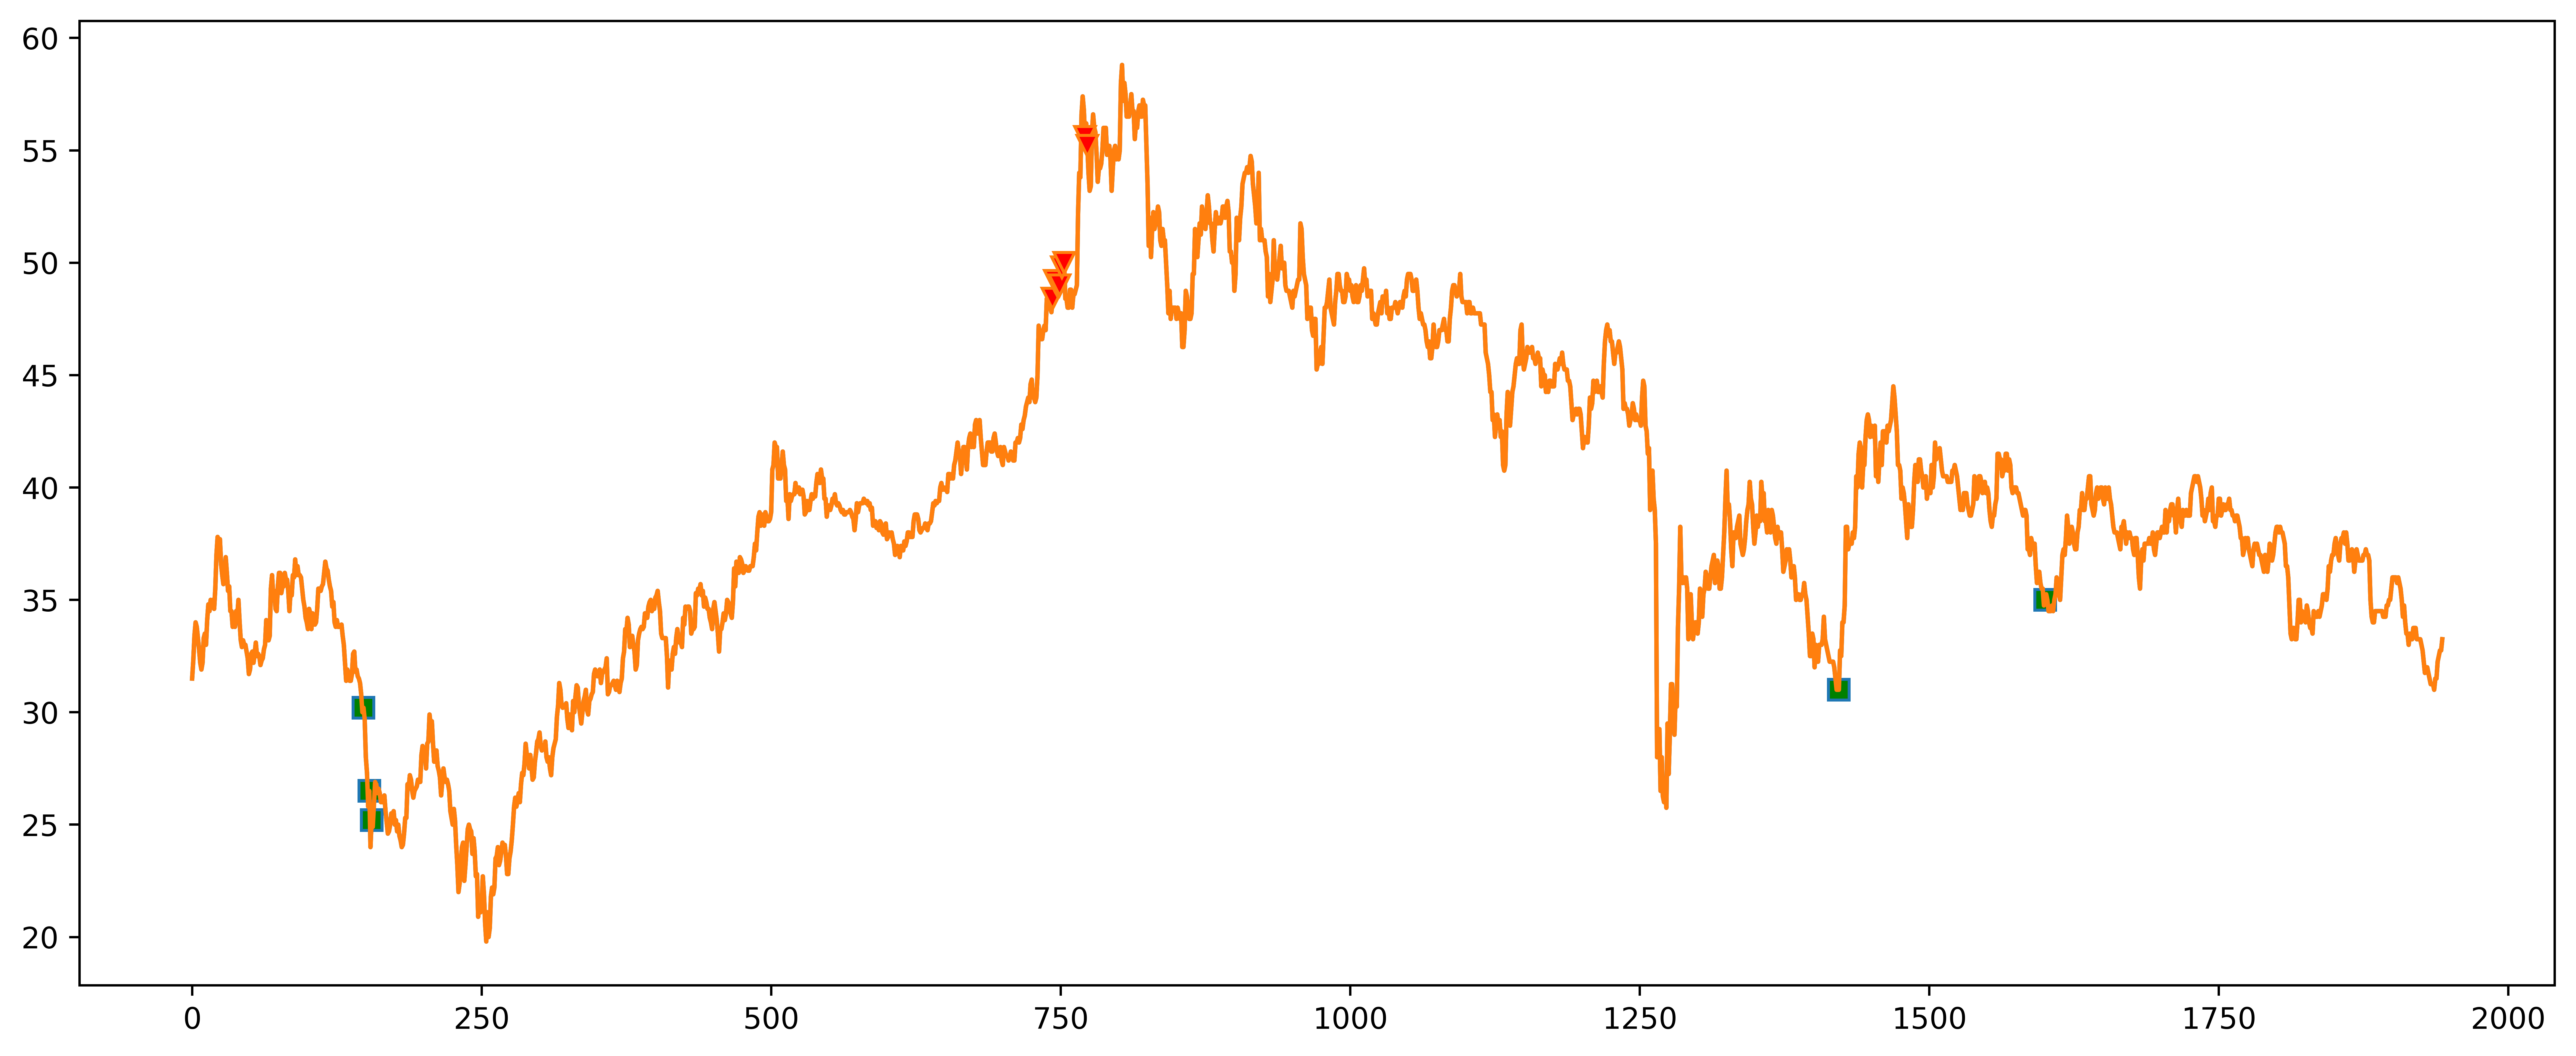

In [371]:
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=720)
plt.plot(il,df_of_PTT_signal_train['close_price'],marker='s',
    markersize=7,markerfacecolor='g',markevery=buy_idx)
plt.plot(il,df_of_PTT_signal_train['close_price'],marker='v',
    markersize=7,markerfacecolor='r',markevery=sell_idx)
plt.show()

In [373]:
us_stock_list=['BA','FDX','AMP','COP','AAPL','TSLA','OXY','XOM','MCD','DIS']
us_stock_list+=['NFLX','PXD','AMZN','META','TROW','TSN','AMD','BABA','CRSP','EA']
us_stock_list+=['NKE','KO','INTC','F','CAT','SBUX','JNJ','QCOM','ADBE','ORCL']
ticker_list=[]
for i,value in enumerate(us_stock_list):
    ticker_list.append(us_stock_list[i])
for i in range(len(us_stock_list)): 
    findindi(ticker_list[i],us_stock_list[i],2015,1,2,2022,12,31) #15-19 18-22
    # globals()['df_of_'+us_stock_list[i]+'_signal_train'].to_csv(us_stock_list[i]+'_1522_years.csv')
thai_stock_list=['CPALL','MINT','HANA', 'BTS','BDMS', 'FORTH','JASIF', 'SCC','CPF','KBANK']
ticker_list=[]
thai_stock_list+=['AOT','CHG','CPN','LPN','IRPC','IT','ADVANC','BBL','BANPU','COM7']
thai_stock_list+=['GULF','JMART','TU','RCL','JAS','BGRIM','RBF','SINGER','ORI','PTT']
for i in range(len(thai_stock_list)):
     ticker_list.append(thai_stock_list[i]+'.BK')
for i,value in enumerate(thai_stock_list):
    findindi(ticker_list[i],thai_stock_list[i],2015,1,2,2022,12,31)
    # globals()['df_of_'+thai_stock_list[i]+'_signal_train'].to_csv(thai_stock_list[i]+'_1522_years.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<ipython-input-3-6fcbf17dda73>:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][hh_idx] = 1
<ipython-input-3-6fcbf17dda73>:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_highs'][lh_idx] = -1
<ipython-input-3-6fcbf17dda73>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{key}_lows'][ll_idx] = 1
<ipython-input-3-6fcbf17dda73>:165: SettingWithCopyWarning: 
A value is trying to be set on a 

In [374]:
all_stock_list=us_stock_list+thai_stock_list
# all_stock_list=thai_stock_list
for j,value in enumerate(all_stock_list): # เเต่ละหุ้น
    data=globals()['df_of_'+all_stock_list[j]+'_signal_train']
    window_size = int(len(data)/(8))
    one_stock_test_l=[]*4
    splittest = [one_stock_test_l for i in range(60)]
    for i in range(0, len(data)-3*window_size,window_size): # เเต่ละ windows
        splittest[j].append(data[i+4*window_size:i+5*window_size])
# all_ticker_list=[]
# for index,value in enumerate(all_stock_list):
#     all_ticker_list.append(locals()[all_stock_list[index]+'_train'])
for i in range(60):
    for j in range(61):
        for k in range(4):
            dfo=splittest[i][k]
            globals()['sl'+str(j+1)+all_stock_list[i]+'_'+str(k)]=dfo[dfo.columns.values[j]]

In [375]:
# for j in range(60): # เเต่ละหุ้น
#     globals()['return_of_'+all_stock_list[j]+'_in_each_signal']=[]
def simulate_one_signal():
    global ret_l,ret_BH
    ret_l = [0] * 61
    ret_BH= 0
    for i in range(1,62): # เเต่ละ signal
        for j in range(60): # เเต่ละหุ้น
            for k in range(4): # เเต่ละ data
                dfo=splittest[j][k]
                sl=(globals()['sl'+str(i)+all_stock_list[j]+'_'+str(k)])
                ret=0
                sumall=0
                amount=0
                mon=1000000
                if (i==1):
                    stocknum = mon/dfo['close_price'][0]
                    ret_BH += ((stocknum*0.998*dfo['close_price'][len(dfo)-1])+(mon-stocknum*dfo['close_price'][0]*1.002))
                for m in range(0,len(dfo)): #เเต่ละวัน
                    r = sl[m]
                    if r==1:
                        sumall=mon//dfo['adj_close_price'][m]
                        amount+=sumall
                        mon-=sumall*dfo['adj_close_price'][m]*1.002
                    elif r==-1:
                        mon+=amount*dfo['adj_close_price'][m]*0.998
                        amount=0
                    else:
                        pass
                ret = mon+amount*dfo['adj_close_price'][len(dfo)-1]
                # globals()['return_of_'+all_stock_list[j]+'_in_each_signal'].append(((ret-100000)/1000))
                ret_l[i-1]+=ret

In [260]:
ret_BH

219804975.91474733

In [376]:
simulate_one_signal()
def Convert(lst,j):
    res_dct = {j[i]:lst[i] for i in range(61)}
    return res_dct

sorted_footballers_by_goals = sorted(Convert(ret_l,dfo.columns).items(), key=lambda x:(x[1]))
converted_dict = dict(sorted_footballers_by_goals)

print(converted_dict)

{'ma25_89_signal': 204621764.31355125, 'ma21_89_signal': 204621764.31355125, 'sma100_signal': 209357542.96460077, 'sma89_signal': 209946018.57110927, 'renko_macdzero_signal': 213017957.77288377, 'ma12_21_signal': 213292563.93952906, 'ma7_16_signal': 213292563.93952906, 'ma50_100_signal': 213961275.85167524, 'ma30_100_signal': 215623698.62662363, 'renko_signal': 218478576.2504451, 'ma5_10_signal': 218707268.51312616, 'vwap_signal': 219079987.46164405, 'fake_obv_renko_signal': 219610122.68788517, 'sma25_signal': 223590646.44546774, 'cdc_signal': 223808804.84372148, 'aroon_signal': 224947835.60764483, 'stoch_signal': 225959618.91449916, 'macd_overzero_signal': 226237487.090566, 'fake_obv_macd_crossover_signal': 227019737.46832272, 'obv_signal': 228914179.55864155, 'ma30_50_signal': 229083216.0285256, 'renko_macd_crossover_signal': 230010451.0139288, 'rsi_signal': 232339495.0148526, 'adx_signal': 232752370.03902644, 'stoch_signal_2': 233043812.07585457, 'ma50_200_signal': 233447004.8660012

In [327]:
import collections
frequency = collections.Counter(rsi_divergent_sto_signal)
print(dict(frequency))

{0: 1920, -1: 6, 1: 18}


In [328]:
import collections
frequency = collections.Counter(rsi_divergent_adx_signal)
print(dict(frequency))

{0: 1833, 1: 96, -1: 15}


In [ ]:
# import collections
# frequency = collections.Counter(real_price)
# print(dict(frequency))

In [ ]:
freq_l = [0] * 52
for i in range(1,53):
    freq=0
    for j in range(60): #เเต่ละหุ้น
    	a=0
    	labels =globals()['sl'+str(i)+all_stock_list[j]].value_counts().keys()
    	values =globals()['sl'+str(i)+all_stock_list[j]].value_counts().values
    	for index,l in enumerate(labels):
            if (l==0):
                a=values[index]
            else:
                a=a
    	freq+=sum(values)-a
    freq_l[i-1]=freq

In [ ]:
def Convert(lst,j):
    res_dct = {j[i]:lst[i] for i in range(52)}
    return res_dct

sorted_footballers_by_goals = sorted(Convert(freq_l,dfo.columns).items(), key=lambda x:x[1])
converted_dict = dict(sorted_footballers_by_goals)

print(converted_dict)

In [ ]:
for i in range(20):
	globals()['return_of_'+all_stock_list[i]+'_in_each_signal']

In [ ]:
len(return_of_BA_in_each_signal)

In [ ]:
#B&H return calculation
def buyandhold(all_ticker_list):
    global buyandhold_return_l,bhvalue
    bhvalue=0
    buyandhold_return_l=[]
    for j in range(60): #เเต่ละหุ้น
        dfo=all_ticker_list[j]
        stocknum=100000/dfo['adj_close_price'][0]
        bhvalue+=(stocknum*(0.998*dfo['adj_close_price'][len(dfo)-1])+((100000-stocknum*dfo['adj_close_price'][0]*1.002)-100000)/1000)
        buyandhold_return_l.append(dfo['adj_close_price'][len(dfo)-1]-dfo['adj_close_price'][0])
buyandhold(all_ticker_list)

In [ ]:
bhvalue

In [ ]:
signal_l=['atr_signal', 'stoch_signal_2', 'stoch_signal', 'cci_signal', 'rsi_signal', 'obv_signal', 'wpr_signal', 'bb_signal', 'sma100_signal', 'rsiandmacd', 'obv_renko_signal',
          'sma89_signal', 'ma30_100_signal', 'roc_signal', 'sar_signal', 'obv_macd_signal', 'stoch_adx_signal', 'psar_signal'
          , 'ma30_50_signal', 'cdc_signal', 'renko_signal', 'adx_signal', 'bb_rsi_signal' , 'macd_signal' , 'ma30_200_signal'
          , 'ma50_200_signal', 'ma50_100_signal', 'aroon_signal', 'renko_macd_signal']

In [ ]:
import pandas as pd
rows=[]
for j in range(20):
    rows.append(globals()['return_of_'+all_stock_list[j]+'_in_each_signal'])
#rows.append(buyandhold_return_l)
df = pd.DataFrame(rows, columns=signal_l)
df['B&H']=buyandhold_return_l
df['Stock']=all_stock_list

In [ ]:
start_date = '2021-01-01'
end_date = '2022-12-31'
ticker_name = "AAPL"
df = yf.download(ticker_name, start_date, end_date)

In [ ]:
v = df['Volume'].values
tp = (df['Low'] + df['Close'] + df['High']).div(3).values
df=df.assign(vwap=(tp * v).cumsum() / v.cumsum())

In [ ]:
plt.plot(df['vwap'])
plt.plot(df['Close'])
plt.show()